<a href="https://colab.research.google.com/github/shilpathota/AI_ML/blob/master/Kubernetes_RL_KISimulator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install Dependencies

In [1]:
!pip -q install gymnasium==0.29.1 stable-baselines3==2.3.2 numpy matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.3/182.3 kB 14.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.1 which is incompatible.


Traffic patterns (ramp / periodic / random / spike) - Simulation

In [2]:
import numpy as np

def traffic_ramp(t, T, low=80, high=800):
    return np.linspace(low, high, T)[t]

def traffic_periodic(t, T, base=400, amp=250, cycles=3):
    return max(1.0, base + amp*np.sin(2*np.pi*cycles*t/T))

def traffic_random(t, T, base=350, noise=200):
    return max(1.0, base + np.random.randn()*noise)

def traffic_spike(t, T, base=250, spike_amp=1200, spike_prob=0.06):
    val = base + np.random.randn()*70
    if np.random.rand() < spike_prob:
        val += spike_amp
    return max(1.0, val)

PATTERNS = ["ramp","periodic","random","spike"]
def draw_load(pattern, t, T):
    if pattern=="ramp":    return traffic_ramp(t,T)
    if pattern=="periodic":return traffic_periodic(t,T)
    if pattern=="random":  return traffic_random(t,T)
    if pattern=="spike":   return traffic_spike(t,T)
    raise ValueError(pattern)


Minimal KIS-Sim environment (Gymnasium)

In [3]:
import gymnasium as gym
from gymnasium import spaces

class KISimEnv(gym.Env):
    """
    Minimal GPU-aware inference cluster sim:
      - Two deployments: CPU replicas and GPU replicas
      - Action: ΔGPU, ΔCPU in {-2..+2}, and placement preference (0=CPU-first, 1=GPU-first)
      - State (10): [active_replicas, gpu_util, p95, throughput, cpu_util, mem_util,
                     d_latency, d_throughput, time_norm, pattern_id_norm]
      - Reward: -α*p95(s) + β*gpu_util - γ*replica_overhead
    Units are scaled for stability, not fidelity.
    """
    metadata = {"render_modes": []}
    def __init__(self,
                 episode_len=240,
                 max_cpu=6,
                 max_gpu=3,
                 gpu_cap_per_replica=520,   # "rps" capacity per GPU replica
                 cpu_cap_per_replica=130,   # "rps" capacity per CPU replica
                 base_latency_cpu_ms=18.0,
                 base_latency_gpu_ms=6.0,
                 alpha=1.0, beta=0.6, gamma=0.25,
                 seed=None):
        super().__init__()
        self.rng = np.random.default_rng(seed)
        self.episode_len = episode_len
        self.max_cpu = max_cpu
        self.max_gpu = max_gpu
        self.gpu_cap = gpu_cap_per_replica
        self.cpu_cap = cpu_cap_per_replica
        self.base_cpu = base_latency_cpu_ms
        self.base_gpu = base_latency_gpu_ms
        self.alpha, self.beta, self.gamma = alpha, beta, gamma

        # Multi-discrete: ΔGPU∈{-2..+2}, ΔCPU∈{-2..+2}, pref∈{0,1}
        self.action_space = spaces.MultiDiscrete(np.array([5,5,2], dtype=np.int64))

        # Observation: 10-dim, each ~[0,1] after internal scaling
        high = np.ones(10, dtype=np.float32)
        self.observation_space = spaces.Box(low=0.0, high=high, shape=(10,), dtype=np.float32)

        self.reset(seed=seed)

    def _choose_pattern(self):
        # Mix patterns across episodes, like the paper
        return self.rng.choice(PATTERNS)

    def _util_to_mem(self, cpu_util, gpu_util):
        # crude: memory rises with replicas; util adds noise
        mem = 0.10 + 0.06*self.cpu_repl + 0.10*self.gpu_repl + 0.05*(cpu_util+gpu_util)
        return float(np.clip(mem, 0.0, 1.0))

    def _p95_ms(self, load_cpu, load_gpu, cap_cpu, cap_gpu):
        # Queueing-like growth as rho→1, with different base latencies
        eps = 1e-6
        rho_cpu = load_cpu/(cap_cpu+eps) if cap_cpu>0 else 0.0
        rho_gpu = load_gpu/(cap_gpu+eps) if cap_gpu>0 else 0.0
        mult_cpu = 1.0 / (1.0 - min(0.995, rho_cpu + 0.02))**2
        mult_gpu = 1.0 / (1.0 - min(0.995, rho_gpu + 0.02))**2
        # weighted by share of served requests
        served = max(eps, load_cpu + load_gpu)
        w_cpu = load_cpu/served
        w_gpu = load_gpu/served
        return w_cpu*self.base_cpu*mult_cpu + w_gpu*self.base_gpu*mult_gpu

    def reset(self, *, seed=None, options=None):
        if seed is not None:
            self.rng = np.random.default_rng(seed)
        self.t = 0
        self.pattern = self._choose_pattern()
        self.cpu_repl = 2
        self.gpu_repl = 0  # start CPU-only
        self.prev_latency = 0.050
        self.prev_throughput = 0.0
        obs = self._observe(throughput=0.0, p95=0.050, cpu_util=0.0, gpu_util=0.0)
        return obs, {}

    def _observe(self, throughput, p95, cpu_util, gpu_util):
        # normalize to [0,1] ranges
        act_repl = (self.cpu_repl + self.gpu_repl) / (self.max_cpu + self.max_gpu)
        p95_norm = float(np.tanh(p95/300.0))  # 300ms scale
        thr_norm = float(np.tanh(throughput/800.0))
        cpu_u = float(np.clip(cpu_util, 0, 1))
        gpu_u = float(np.clip(gpu_util, 0, 1))
        dlat = float(np.clip((p95 - self.prev_latency)/120.0 + 0.5, 0, 1))
        dthr = float(np.clip((throughput - self.prev_throughput)/400.0 + 0.5, 0, 1))
        time_norm = self.t / self.episode_len
        pat_id = PATTERNS.index(self.pattern) / (len(PATTERNS)-1)  # 0..1
        mem_util = self._util_to_mem(cpu_u, gpu_u)
        obs = np.array([act_repl, gpu_u, p95_norm, thr_norm, cpu_u, mem_util,
                        dlat, dthr, time_norm, pat_id], dtype=np.float32)
        return obs

    def step(self, action):
        # decode action
        d_gpu = int(action[0]) - 2
        d_cpu = int(action[1]) - 2
        pref  = int(action[2])      # 0=CPU-first, 1=GPU-first

        # apply scaling
        self.cpu_repl = int(np.clip(self.cpu_repl + d_cpu, 0, self.max_cpu))
        self.gpu_repl = int(np.clip(self.gpu_repl + d_gpu, 0, self.max_gpu))

        # incoming load (qps)
        L = draw_load(self.pattern, self.t, self.episode_len)

        cap_cpu = self.cpu_repl * self.cpu_cap
        cap_gpu = self.gpu_repl * self.gpu_cap

        # placement preference: fill preferred partition first
        load_cpu = load_gpu = 0.0
        if pref==1:  # GPU-first
            take_gpu = min(L, cap_gpu)
            load_gpu = take_gpu
            load_cpu = min(L - take_gpu, cap_cpu)
        else:        # CPU-first
            take_cpu = min(L, cap_cpu)
            load_cpu = take_cpu
            load_gpu = min(L - take_cpu, cap_gpu)

        served = load_cpu + load_gpu
        throughput = served  # rps

        # utils (0..1)
        cpu_util = (load_cpu/cap_cpu) if cap_cpu>0 else 0.0
        gpu_util = (load_gpu/cap_gpu) if cap_gpu>0 else 0.0

        p95 = self._p95_ms(load_cpu, load_gpu, cap_cpu, cap_gpu)

        # reward: lower p95, prefer GPU util, penalize replicas
        over = 0.3*self.cpu_repl + 0.6*self.gpu_repl  # GPUs "cost" more
        reward = -self.alpha*(p95/1000.0) + self.beta*gpu_util - self.gamma*(over/10.0)

        obs = self._observe(throughput, p95, cpu_util, gpu_util)
        self.prev_latency = p95
        self.prev_throughput = throughput

        self.t += 1
        terminated = (self.t >= self.episode_len)
        truncated = False
        info = {"p95_ms": p95, "throughput": throughput, "cpu_util": cpu_util, "gpu_util": gpu_util, "load": L}
        return obs, float(reward), terminated, truncated, info


Quick sanity run (random policy) and plotting

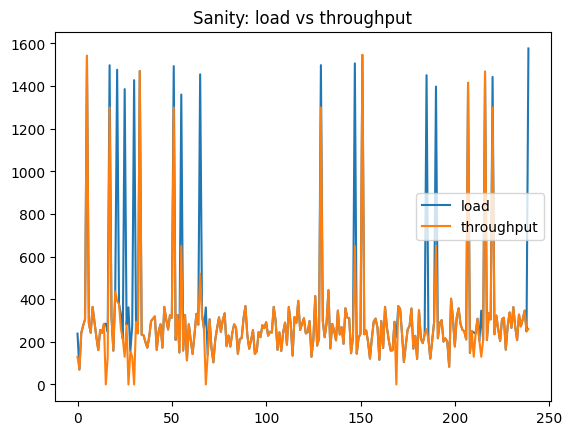

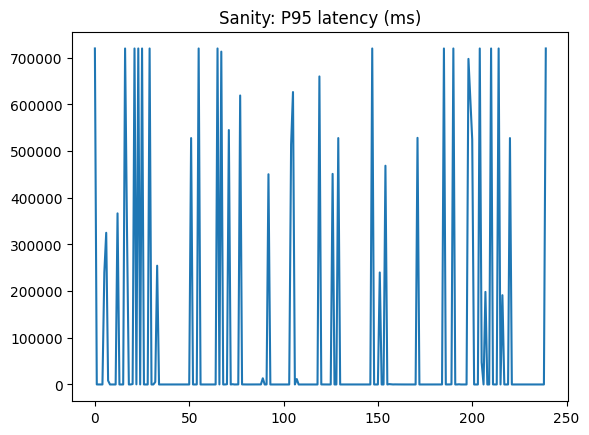

In [4]:
import matplotlib.pyplot as plt

env = KISimEnv(episode_len=240, seed=42)
obs, _ = env.reset()
lat, thru, load = [], [], []
for _ in range(env.episode_len):
    a = env.action_space.sample()
    obs, r, done, trunc, info = env.step(a)
    lat.append(info["p95_ms"]); thru.append(info["throughput"]); load.append(info["load"])
    if done: break

plt.figure(); plt.title("Sanity: load vs throughput"); plt.plot(load, label="load"); plt.plot(thru, label="throughput"); plt.legend()
plt.figure(); plt.title("Sanity: P95 latency (ms)"); plt.plot(lat); plt.show()


Train PPO autoscaler (lightweight)

In [5]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env

train_env = make_vec_env(lambda: KISimEnv(episode_len=240), n_envs=4)  # vectorized for speed
model = PPO("MlpPolicy", train_env, verbose=0, n_steps=512, batch_size=1024, learning_rate=3e-4, gamma=0.995, gae_lambda=0.95, ent_coef=0.01, tensorboard_log=None)
model.learn(total_timesteps=120_000)  # ~a few minutes on Colab CPU
model.save("ppo_kissim.zip")


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=

Evaluate PPO vs a simple threshold baseline (CPU-first HPA-ish)

In [6]:
def eval_policy(policy=None, episodes=8):
    results = []
    for ep in range(episodes):
        env = KISimEnv(episode_len=240, seed=ep*7+1)
        obs, _ = env.reset()
        p95s=[]; thr=[]; loads=[]
        while True:
            if policy is None:
                # CPU-first threshold baseline: if p95>150ms → add CPU; if load>cap_cpu*0.8 → add "GPU"
                act = np.array([2, 2, 0])  # Δ=0, Δ=0, pref=CPU-first
                # peek at obs: index 2 ~ p95_norm
                # simple heuristic using last info is cleaner; we’ll probe env internals via info after one no-op
            else:
                act, _ = policy.predict(obs, deterministic=True)

            obs, r, done, trunc, info = env.step(act)

            # crude HPA-ish for the baseline after we have info:
            if policy is None:
                # if p95 high → scale CPU; if throughput < load*0.9 and CPU near cap → add "GPU"
                if info["p95_ms"] > 150 and env.cpu_repl < env.max_cpu:
                    env.cpu_repl = min(env.max_cpu, env.cpu_repl + 1)
                elif info["load"] > (env.cpu_repl*env.cpu_cap*0.9) and env.gpu_repl < 1:
                    env.gpu_repl = min(env.max_gpu, env.gpu_repl + 1)

            p95s.append(info["p95_ms"]); thr.append(info["throughput"]); loads.append(info["load"])
            if done: break
        results.append((np.array(p95s), np.array(thr), np.array(loads)))
    return results

ppo_results = eval_policy(policy=model, episodes=8)
base_results = eval_policy(policy=None, episodes=8)

def summarize(results, name):
    p95_all = np.concatenate([r[0] for r in results])
    thr_all = np.concatenate([r[1] for r in results])
    ld_all  = np.concatenate([r[2] for r in results])
    print(f"{name}: P95(ms) mean={p95_all.mean():.1f}, median={np.median(p95_all):.1f}, 95th={np.percentile(p95_all,95):.1f}")
    print(f"{name}: Throughput mean={thr_all.mean():.1f} rps | Mean load={ld_all.mean():.1f} rps")

summarize(ppo_results, "PPO")
summarize(base_results,"Baseline")


PPO: P95(ms) mean=153.4, median=10.5, 95th=21.6
PPO: Throughput mean=380.7 rps | Mean load=380.7 rps
Baseline: P95(ms) mean=24937.8, median=85.6, 95th=5998.9
Baseline: Throughput mean=381.4 rps | Mean load=384.9 rps


Visual comparison (one episode)

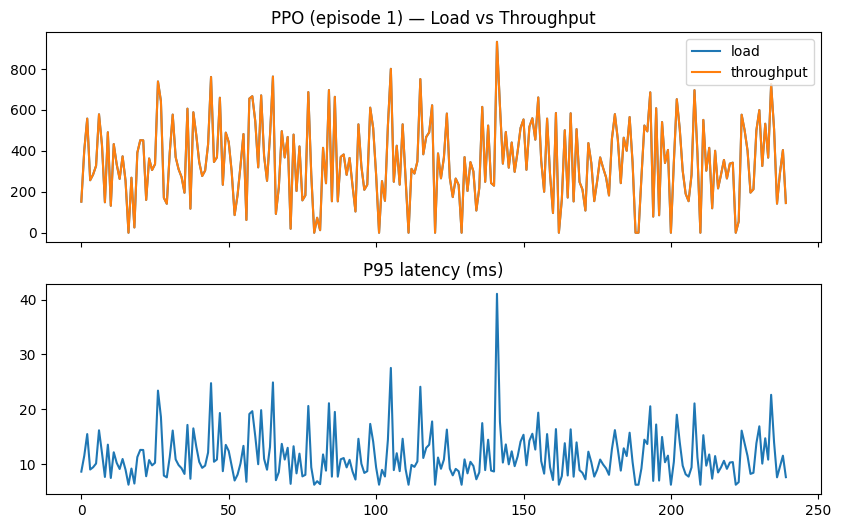

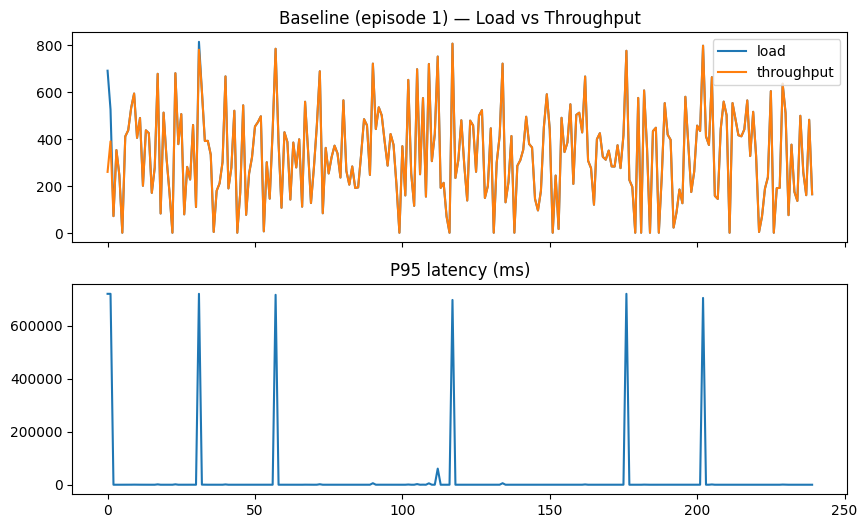

In [7]:
def plot_episode(res, title):
    p95, thr, ld = res
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(2,1, figsize=(10,6), sharex=True)
    ax[0].plot(ld, label="load"); ax[0].plot(thr, label="throughput")
    ax[0].legend(); ax[0].set_title(title + " — Load vs Throughput")
    ax[1].plot(p95); ax[1].set_title("P95 latency (ms)")
    plt.show()

plot_episode(ppo_results[0], "PPO (episode 1)")
plot_episode(base_results[0], "Baseline (episode 1)")


Download the trained policy

In [8]:
# In Colab, this will prompt a download in the browser
try:
    from google.colab import files
    files.download("ppo_kissim.zip")
except Exception as e:
    print("Download skipped:", e)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>